### Load libraries

In [1]:
#load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import wilcoxon
from itertools import combinations

### Read data

In [38]:
icer = pd.read_csv('../data/processed/icer_observed.csv')
low = gpd.read_file('../data/processed/low_res.shp')
high = gpd.read_file('../data/processed/high_res.shp')
rf_preds = pd.read_csv('../data/processed/df_combined_with_predictions_rf.csv')

### Process data

In [39]:
#first method of disaggregation, divide the cases evenly among all the districts
#firstly, extract the total number of cases in DKI Jakarta, so high['Cases'] when high['Province'] == 'DKI Jakarta', for every year
df_jakarta = low[low['Province'] == 'DKI Jakarta']
df_java = low[low['Province'] == 'Jawa Barat']

df_jakarta.head()

,Province,Year,Cases,Population,HDI,Area_sq_km,Pop_den,urbanicity,hdi_qt,popden_qt,urban_qt,geometry
0,DKI Jakarta,2020,1226,804069,0.803450,664.01,1210.929052,0.918091,0.180012,-0.180012,5.199338,"MULTIPOLYGON (((106.87677 -6.1003, 106.87596 -..."
1,DKI Jakarta,2021,1061,799633,0.806333,664.01,1204.248430,0.918091,0.565949,-0.565949,5.199338,"MULTIPOLYGON (((106.87677 -6.1003, 106.87596 -..."
2,DKI Jakarta,2022,2123,795198,0.811467,661.23,1202.604238,0.918091,1.067571,-1.067571,5.199338,"MULTIPOLYGON (((106.87677 -6.1003, 106.87596 -..."
3,DKI Jakarta,2023,1564,790763,0.817083,660.98,1196.349360,0.918091,5.199338,-5.199338,5.199338,"MULTIPOLYGON (((106.87677 -6.1003, 106.87596 -..."


In [40]:
#create a dataframe containing total number of cases in dengue in each year from dki jakarta n west java df
df_jakarta_yearly_total_cases = pd.DataFrame(df_jakarta.groupby('Year')['Cases'].sum())
df_java_yearly_total_cases = pd.DataFrame(df_java.groupby('Year')['Cases'].sum())

In [41]:
#check head
df_jakarta_yearly_total_cases.head()

,Cases
Year,
2020,1226
2021,1061
2022,2123
2023,1564


### Disaggregation with equal proportions and ICER adjustments

In [42]:
#from this, extract the total number of districts in DKI Jakarta from high df, so count the number of unique values of district when province column = dki jakarta
df_jakarta_districts = len(pd.DataFrame(high[high['Province'] == 'DKI Jakarta']['District'].unique()))
df_java_districts = len(pd.DataFrame(high[high['Province'] == 'Jawa Barat']['District'].unique()))

In [43]:
print(df_jakarta_districts)

6


In [44]:
#list out all the district - level dengue cases estimates each year
year_2020_jkt = int(df_jakarta_yearly_total_cases.loc[2020] / df_jakarta_districts)
year_2021_jkt = int(df_jakarta_yearly_total_cases.loc[2021] / df_jakarta_districts)
year_2022_jkt = int(df_jakarta_yearly_total_cases.loc[2022] / df_jakarta_districts)
year_2023_jkt = int(df_jakarta_yearly_total_cases.loc[2023] / df_jakarta_districts)

year_2020_java = int(df_java_yearly_total_cases.loc[2020] / df_java_districts)
year_2021_java = int(df_java_yearly_total_cases.loc[2021] / df_java_districts)
year_2022_java = int(df_java_yearly_total_cases.loc[2022] / df_java_districts)
year_2023_java = int(df_java_yearly_total_cases.loc[2023] / df_java_districts)

C:\Users\jessi\AppData\Local\Temp\ipykernel_7844\516498921.py:2: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  year_2020_jkt = int(df_jakarta_yearly_total_cases.loc[2020] / df_jakarta_districts)
C:\Users\jessi\AppData\Local\Temp\ipykernel_7844\516498921.py:3: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  year_2021_jkt = int(df_jakarta_yearly_total_cases.loc[2021] / df_jakarta_districts)
C:\Users\jessi\AppData\Local\Temp\ipykernel_7844\516498921.py:4: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  year_2022_jkt = int(df_jakarta_yearly_total_cases.loc[2022] / df_jakarta_districts)
C:\Users\jessi\AppData\Local\Temp\ipykernel_7844\516498921.py:5: FutureWarning: Calling int on a single element Series is deprecat

In [45]:
#append the disaggregated counts to the high_res file ina  new column called cases_bm_equal, only if the Province column is dki jakarta
high.loc[(high['Province'] == 'DKI Jakarta') & (high['Year'] == 2020), 'cases_bm_equal'] = year_2020_jkt
high.loc[(high['Province'] == 'DKI Jakarta') & (high['Year'] == 2021), 'cases_bm_equal'] = year_2021_jkt
high.loc[(high['Province'] == 'DKI Jakarta') & (high['Year'] == 2022), 'cases_bm_equal'] = year_2022_jkt
high.loc[(high['Province'] == 'DKI Jakarta') & (high['Year'] == 2023), 'cases_bm_equal'] = year_2023_jkt

high.loc[(high['Province'] == 'Jawa Barat') & (high['Year'] == 2020), 'cases_bm_equal'] = year_2020_java
high.loc[(high['Province'] == 'Jawa Barat') & (high['Year'] == 2021), 'cases_bm_equal'] = year_2021_java
high.loc[(high['Province'] == 'Jawa Barat') & (high['Year'] == 2022), 'cases_bm_equal'] = year_2022_java
high.loc[(high['Province'] == 'Jawa Barat') & (high['Year'] == 2023), 'cases_bm_equal'] = year_2023_java

In [46]:
high.head()

,District,Year,Area_sq_km,HDI,Province,Cases,Population,Pop_den,urbanicity,hdi_qt,popden_qt,urban_qt,geometry,cases_bm_equal
0,BANDUNG,2020,1767.96,0.7239,Jawa Barat,2295,3623790,2049.701351,0.123155,0.009567,0.423740,-0.153679,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",837.0
1,BANDUNG,2021,1767.96,0.7273,Jawa Barat,2002,3665655,2073.381185,0.123155,0.067021,0.465992,-0.153679,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",886.0
2,BANDUNG,2022,1767.96,0.7316,Jawa Barat,4191,3707523,2097.062716,0.123155,0.144005,0.487429,-0.153679,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",1346.0
3,BANDUNG,2023,1767.96,0.7374,Jawa Barat,1005,3749391,2120.744248,0.123155,0.221854,0.509093,-0.153679,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",715.0
4,BANDUNG BARAT,2020,1305.77,0.6808,Jawa Barat,966,1788336,1369.564318,0.079001,-1.057954,-0.028706,-0.476683,"POLYGON ((107.40945 -6.68851, 107.40986 -6.688...",837.0


In [47]:
#merge this with icer df
icer = pd.merge(icer, high[['Province', 'District', 'Year', 'cases_bm_equal']], on=['Province', 'District', 'Year'], how='left')

In [48]:
icer.head()

,Unnamed: 0,District,Province,Population,Year,icer_healthcare_observed,icer_payer_observed,qaly_le_scaled_vaccine,qaly_le_scaled_nonvaccine,burden_non_vaccine,burden_vaccine,healthcare_cost_non_vaccine,healthcare_cost_vaccine,payer_cost_non_vaccine,payer_cost_vaccine,cases_bm_equal
0,0,BANDUNG,Jawa Barat,3623790,2020,5408.317941,5461.702270,134829.060662,195145.431036,382416,264217,26618814,352828922,16066984,345497041,837.0
1,1,BANDUNG,Jawa Barat,3665655,2021,5402.967419,5456.298935,134962.580953,195338.682213,382416,264217,26618814,352828922,16066984,345497041,886.0
2,2,BANDUNG,Jawa Barat,3707523,2022,5402.965214,5456.296708,134962.636029,195338.761927,382416,264217,26618814,352828922,16066984,345497041,1346.0
3,3,BANDUNG,Jawa Barat,3749391,2023,5404.945422,5458.296463,134913.189810,195267.195726,382416,264217,26618814,352828922,16066984,345497041,715.0
4,4,BANDUNG BARAT,Jawa Barat,1788336,2020,5497.285294,5551.547801,132647.004601,191987.222646,382416,264217,26618814,352828922,16066984,345497041,837.0


In [49]:
#calculate ICER for disaggregation with equal proportions
# Scale total cost to produce district-level cost per year based on cases per district per year / total num of cases over 2020-2024 nationwide, assuming that healthcare costs for dengue treatment is linearly related to the number of dengue cases per year
# this cost factor measures the scale of the district-level, yearly dengue cases to the national-level dengue cases in total from 2020-2024.
icer['cost_factor'] = icer['cases_bm_equal'] / (icer['burden_non_vaccine'] + icer['burden_vaccine'])

icer['qaly_lost_scaled_vaccine'] = icer['qaly_le_scaled_vaccine'] * icer['cost_factor']
icer['qaly_lost_scaled_nonvaccine'] = icer['qaly_le_scaled_nonvaccine'] * icer['cost_factor']


In [50]:
# Scale costs
icer['healthcare_cost_vaccine_scaled'] = icer['healthcare_cost_vaccine'] * icer['cost_factor']
icer['healthcare_cost_nonvaccine_scaled'] = icer['healthcare_cost_non_vaccine'] * icer['cost_factor']
icer['payer_cost_vaccine_scaled'] = icer['payer_cost_vaccine'] * icer['cost_factor']
icer['payer_cost_nonvaccine_scaled'] = icer['payer_cost_non_vaccine'] * icer['cost_factor']

In [51]:
#compute icer
icer['icer_healthcare_equal_bm'] = abs(icer['healthcare_cost_vaccine_scaled'] - icer['healthcare_cost_nonvaccine_scaled']) / abs(icer['qaly_lost_scaled_vaccine'] - icer['qaly_lost_scaled_nonvaccine'])
icer['icer_payer_equal_bm'] = abs(icer['payer_cost_vaccine_scaled'] - icer['payer_cost_nonvaccine_scaled']) / abs(icer['qaly_lost_scaled_vaccine'] - icer['qaly_lost_scaled_nonvaccine'])

### Population-proportion disaggregation and icer calculations

In [52]:
#get df containing yearly total populations
df_jakarta_yearly_total_pop = pd.DataFrame(df_jakarta.groupby('Year')['Population'].sum())
df_java_yearly_total_pop = pd.DataFrame(df_java.groupby('Year')['Population'].sum())

df_jakarta_yearly_total_pop.head()

,Population
Year,
2020,804069
2021,799633
2022,795198
2023,790763


In [53]:
#merge the two dfs by Year
df_jakarta_final = df_jakarta_yearly_total_cases.merge(df_jakarta_yearly_total_pop, on='Year')
df_java_final = df_java_yearly_total_cases.merge(df_java_yearly_total_pop, on='Year')

#get another column called df_jakarta_final and df_java_final called Province, for merging
df_jakarta_final['Province'] = 'DKI Jakarta'
df_java_final['Province'] = 'Jawa Barat'

#append the suffix _Prov to both "Cases" and "Population" c0olumns in df_jakarta_final and df_java_final:
df_jakarta_final.columns = [col + '_Prov' if col in ['Cases', 'Population'] else col for col in df_jakarta_final.columns]
df_java_final.columns = [col + '_Prov' if col in ['Cases', 'Population'] else col for col in df_java_final.columns]

In [54]:
# Reset index of df_jakarta_final and df_java_final to make 'Year' a regular column
df_jakarta_final = df_jakarta_final.reset_index()
df_java_final = df_java_final.reset_index()
#check
df_jakarta_final.head()

,Year,Cases_Prov,Population_Prov,Province
0,2020,1226,804069,DKI Jakarta
1,2021,1061,799633,DKI Jakarta
2,2022,2123,795198,DKI Jakarta
3,2023,1564,790763,DKI Jakarta


In [55]:
#merge df_jakarta_final and df_java_final tgt by row
df_final = pd.concat([df_jakarta_final, df_java_final], axis=0)

In [56]:
#now appd this to the high-res dataset: so it means that if the year is 2020 cases_prop_bm = high_res["Population"]/df_jakarta_final["Population"] * df_jakarta_final["Cases"]

#merge to the high_res df by Year and Province
high = pd.merge(high, df_final[['Year', 'Province', 'Population_Prov', 'Cases_Prov']], on=['Year', 'Province'], how='left')


In [57]:
high.head()

,District,Year,Area_sq_km,HDI,Province,Cases,Population,Pop_den,urbanicity,hdi_qt,popden_qt,urban_qt,geometry,cases_bm_equal,Population_Prov,Cases_Prov
0,BANDUNG,2020,1767.96,0.7239,Jawa Barat,2295,3623790,2049.701351,0.123155,0.009567,0.423740,-0.153679,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",837.0,48274162,22613
1,BANDUNG,2021,1767.96,0.7273,Jawa Barat,2002,3665655,2073.381185,0.123155,0.067021,0.465992,-0.153679,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",886.0,48778844,23948
2,BANDUNG,2022,1767.96,0.7316,Jawa Barat,4191,3707523,2097.062716,0.123155,0.144005,0.487429,-0.153679,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",1346.0,49283556,36365
3,BANDUNG,2023,1767.96,0.7374,Jawa Barat,1005,3749391,2120.744248,0.123155,0.221854,0.509093,-0.153679,"POLYGON ((107.73309 -6.814, 107.73354 -6.81427...",715.0,49788238,19328
4,BANDUNG BARAT,2020,1305.77,0.6808,Jawa Barat,966,1788336,1369.564318,0.079001,-1.057954,-0.028706,-0.476683,"POLYGON ((107.40945 -6.68851, 107.40986 -6.688...",837.0,48274162,22613


In [58]:
#calculate the disaggregation by multiplying the total num of cases per province with the pop in the district / pop in the province
high['cases_prop_bm'] = high['Population'] / high['Population_Prov'] * high['Cases_Prov']

In [59]:
#icer calculations
#merge this with icer df
icer = pd.merge(icer, high[['Province', 'District', 'Year', 'cases_prop_bm']], on=['Province', 'District', 'Year'], how='left')

In [60]:
#calculate ICER for disaggregation with population-based proportions
# Scale total cost to produce district-level cost per year based on cases per district per year / total num of cases over 2020-2024 nationwide, assuming that healthcare costs for dengue treatment is linearly related to the number of dengue cases per year
# this cost factor measures the scale of the district-level, yearly dengue cases to the national-level dengue cases in total from 2020-2024.
icer['cost_factor'] = icer['cases_prop_bm'] / (icer['burden_non_vaccine'] + icer['burden_vaccine'])

icer['qaly_lost_scaled_vaccine'] = icer['qaly_le_scaled_vaccine'] * icer['cost_factor']
icer['qaly_lost_scaled_nonvaccine'] = icer['qaly_le_scaled_nonvaccine'] * icer['cost_factor']


In [61]:
# Scale costs
icer['healthcare_cost_vaccine_scaled'] = icer['healthcare_cost_vaccine'] * icer['cost_factor']
icer['healthcare_cost_nonvaccine_scaled'] = icer['healthcare_cost_non_vaccine'] * icer['cost_factor']
icer['payer_cost_vaccine_scaled'] = icer['payer_cost_vaccine'] * icer['cost_factor']
icer['payer_cost_nonvaccine_scaled'] = icer['payer_cost_non_vaccine'] * icer['cost_factor']

In [62]:
#compute icer
icer['icer_healthcare_prop_bm'] = abs(icer['healthcare_cost_vaccine_scaled'] - icer['healthcare_cost_nonvaccine_scaled']) / abs(icer['qaly_lost_scaled_vaccine'] - icer['qaly_lost_scaled_nonvaccine'])
icer['icer_payer_prop_bm'] = abs(icer['payer_cost_vaccine_scaled'] - icer['payer_cost_nonvaccine_scaled']) / abs(icer['qaly_lost_scaled_vaccine'] - icer['qaly_lost_scaled_nonvaccine'])

In [63]:
icer.head()

,Unnamed: 0,District,Province,Population,Year,icer_healthcare_observed,icer_payer_observed,qaly_le_scaled_vaccine,qaly_le_scaled_nonvaccine,burden_non_vaccine,...,qaly_lost_scaled_nonvaccine,healthcare_cost_vaccine_scaled,healthcare_cost_nonvaccine_scaled,payer_cost_vaccine_scaled,payer_cost_nonvaccine_scaled,icer_healthcare_equal_bm,icer_payer_equal_bm,cases_prop_bm,icer_healthcare_prop_bm,icer_payer_prop_bm
0,0,BANDUNG,Jawa Barat,3623790,2020,5408.317941,5461.702270,134829.060662,195145.431036,382416,...,512.279509,9.262171e+05,69877.490297,9.069700e+05,42177.706285,5408.317941,5461.702270,1697.487017,5408.317941,5461.702270
1,1,BANDUNG,Jawa Barat,3665655,2021,5402.967419,5456.298935,134962.580953,195338.682213,382416,...,543.650414,9.819642e+05,74083.274648,9.615587e+05,44716.296843,5402.967419,5456.298935,1799.655317,5402.967419,5456.298935
2,2,BANDUNG,Jawa Barat,3707523,2022,5402.965214,5456.296708,134962.636029,195338.761927,382416,...,826.410784,1.492697e+06,112615.001419,1.461679e+06,67973.855859,5402.965214,5456.296708,2735.680719,5402.965214,5456.296708
3,3,BANDUNG,Jawa Barat,3749391,2023,5404.945422,5458.296463,134913.189810,195267.195726,382416,...,439.533840,7.941951e+05,59917.230307,7.776915e+05,36165.742796,5404.945422,5458.296463,1455.529100,5404.945422,5458.296463
4,4,BANDUNG BARAT,Jawa Barat,1788336,2020,5497.285294,5551.547801,132647.004601,191987.222646,382416,...,248.717887,4.570870e+05,34484.457291,4.475886e+05,20814.647247,5497.285294,5551.547801,837.707798,5497.285294,5551.547801


### Random-forest-based (hdi and pop den) aggregation and icer calculations

In [64]:
rf_preds.head()

,Unnamed: 0,District,Year,Area_sq_km,HDI,Province,Cases,Population,Pop_den,urbanicity,hdi_qt,popden_qt,urban_qt,geometry,Predicted_Cases
0,0,BANDUNG,2020,1767.96,0.7239,Jawa Barat,2295,3623790,2049.701351,0.123155,0.009567,0.423740,-0.153679,POLYGON ((107.73309340000009 -6.81399609999994...,NaN
1,1,BANDUNG,2021,1767.96,0.7273,Jawa Barat,2002,3665655,2073.381185,0.123155,0.067021,0.465992,-0.153679,POLYGON ((107.73309340000009 -6.81399609999994...,NaN
2,2,BANDUNG,2022,1767.96,0.7316,Jawa Barat,4191,3707523,2097.062716,0.123155,0.144005,0.487429,-0.153679,POLYGON ((107.73309340000009 -6.81399609999994...,NaN
3,3,BANDUNG,2023,1767.96,0.7374,Jawa Barat,1005,3749391,2120.744248,0.123155,0.221854,0.509093,-0.153679,POLYGON ((107.73309340000009 -6.81399609999994...,1504.227676
4,4,BANDUNG BARAT,2020,1305.77,0.6808,Jawa Barat,966,1788336,1369.564318,0.079001,-1.057954,-0.028706,-0.476683,POLYGON ((107.40945450000004 -6.68851489999997...,NaN


In [65]:
#merge the rf_preds cases to the high and icer dfs:
#rename Predicted_Cases to rf_preds
rf_preds = rf_preds.rename(columns={'Predicted_Cases': 'rf_preds'})
high = pd.merge(high, rf_preds[['Population', 'Cases', 'Year', 'rf_preds', 'District']], on=['Population', 'Cases', 'Year', 'District'], how='left')
icer = pd.merge(icer, rf_preds[['Population', 'Cases', 'Year', 'rf_preds', 'District']], on=['Population', 'Year', 'District'], how='left')

In [66]:
icer.head()

,Unnamed: 0,District,Province,Population,Year,icer_healthcare_observed,icer_payer_observed,qaly_le_scaled_vaccine,qaly_le_scaled_nonvaccine,burden_non_vaccine,...,healthcare_cost_nonvaccine_scaled,payer_cost_vaccine_scaled,payer_cost_nonvaccine_scaled,icer_healthcare_equal_bm,icer_payer_equal_bm,cases_prop_bm,icer_healthcare_prop_bm,icer_payer_prop_bm,Cases,rf_preds
0,0,BANDUNG,Jawa Barat,3623790,2020,5408.317941,5461.702270,134829.060662,195145.431036,382416,...,69877.490297,9.069700e+05,42177.706285,5408.317941,5461.702270,1697.487017,5408.317941,5461.702270,2295,NaN
1,1,BANDUNG,Jawa Barat,3665655,2021,5402.967419,5456.298935,134962.580953,195338.682213,382416,...,74083.274648,9.615587e+05,44716.296843,5402.967419,5456.298935,1799.655317,5402.967419,5456.298935,2002,NaN
2,2,BANDUNG,Jawa Barat,3707523,2022,5402.965214,5456.296708,134962.636029,195338.761927,382416,...,112615.001419,1.461679e+06,67973.855859,5402.965214,5456.296708,2735.680719,5402.965214,5456.296708,4191,NaN
3,3,BANDUNG,Jawa Barat,3749391,2023,5404.945422,5458.296463,134913.189810,195267.195726,382416,...,59917.230307,7.776915e+05,36165.742796,5404.945422,5458.296463,1455.529100,5404.945422,5458.296463,1005,1504.227676
4,4,BANDUNG BARAT,Jawa Barat,1788336,2020,5497.285294,5551.547801,132647.004601,191987.222646,382416,...,34484.457291,4.475886e+05,20814.647247,5497.285294,5551.547801,837.707798,5497.285294,5551.547801,966,NaN


In [67]:
# calculate icer for rf
# calculate ICER for disaggregation with population-based proportions
# Scale total cost to produce district-level cost per year based on cases per district per year / total num of cases over 2020-2024 nationwide, assuming that healthcare costs for dengue treatment is linearly related to the number of dengue cases per year
# this cost factor measures the scale of the district-level, yearly dengue cases to the national-level dengue cases in total from 2020-2024.
icer['cost_factor'] = icer['rf_preds'] / (icer['burden_non_vaccine'] + icer['burden_vaccine'])

icer['qaly_lost_scaled_vaccine'] = icer['qaly_le_scaled_vaccine'] * icer['cost_factor']
icer['qaly_lost_scaled_nonvaccine'] = icer['qaly_le_scaled_nonvaccine'] * icer['cost_factor']

In [68]:
# Scale costs
icer['healthcare_cost_vaccine_scaled'] = icer['healthcare_cost_vaccine'] * icer['cost_factor']
icer['healthcare_cost_nonvaccine_scaled'] = icer['healthcare_cost_non_vaccine'] * icer['cost_factor']
icer['payer_cost_vaccine_scaled'] = icer['payer_cost_vaccine'] * icer['cost_factor']
icer['payer_cost_nonvaccine_scaled'] = icer['payer_cost_non_vaccine'] * icer['cost_factor']

In [69]:
#compute icer
icer['icer_healthcare_rf'] = abs(icer['healthcare_cost_vaccine_scaled'] - icer['healthcare_cost_nonvaccine_scaled']) / abs(icer['qaly_lost_scaled_vaccine'] - icer['qaly_lost_scaled_nonvaccine'])
icer['icer_payer_rf'] = abs(icer['payer_cost_vaccine_scaled'] - icer['payer_cost_nonvaccine_scaled']) / abs(icer['qaly_lost_scaled_vaccine'] - icer['qaly_lost_scaled_nonvaccine'])

In [70]:
icer.head()

,Unnamed: 0,District,Province,Population,Year,icer_healthcare_observed,icer_payer_observed,qaly_le_scaled_vaccine,qaly_le_scaled_nonvaccine,burden_non_vaccine,...,payer_cost_nonvaccine_scaled,icer_healthcare_equal_bm,icer_payer_equal_bm,cases_prop_bm,icer_healthcare_prop_bm,icer_payer_prop_bm,Cases,rf_preds,icer_healthcare_rf,icer_payer_rf
0,0,BANDUNG,Jawa Barat,3623790,2020,5408.317941,5461.702270,134829.060662,195145.431036,382416,...,NaN,5408.317941,5461.702270,1697.487017,5408.317941,5461.702270,2295,NaN,NaN,NaN
1,1,BANDUNG,Jawa Barat,3665655,2021,5402.967419,5456.298935,134962.580953,195338.682213,382416,...,NaN,5402.967419,5456.298935,1799.655317,5402.967419,5456.298935,2002,NaN,NaN,NaN
2,2,BANDUNG,Jawa Barat,3707523,2022,5402.965214,5456.296708,134962.636029,195338.761927,382416,...,NaN,5402.965214,5456.296708,2735.680719,5402.965214,5456.296708,4191,NaN,NaN,NaN
3,3,BANDUNG,Jawa Barat,3749391,2023,5404.945422,5458.296463,134913.189810,195267.195726,382416,...,37375.763373,5404.945422,5458.296463,1455.529100,5404.945422,5458.296463,1005,1504.227676,5404.945422,5458.296463
4,4,BANDUNG BARAT,Jawa Barat,1788336,2020,5497.285294,5551.547801,132647.004601,191987.222646,382416,...,NaN,5497.285294,5551.547801,837.707798,5497.285294,5551.547801,966,NaN,NaN,NaN


# Evaluate the Predicted Cases produced by different methods

### Evaluate the ICER calculations produced by different models and which one is closest to the observed ones



 ICER Evaluation from Healthcare Provider's Perspective


C:\Users\jessi\AppData\Local\Temp\ipykernel_7844\2680994249.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


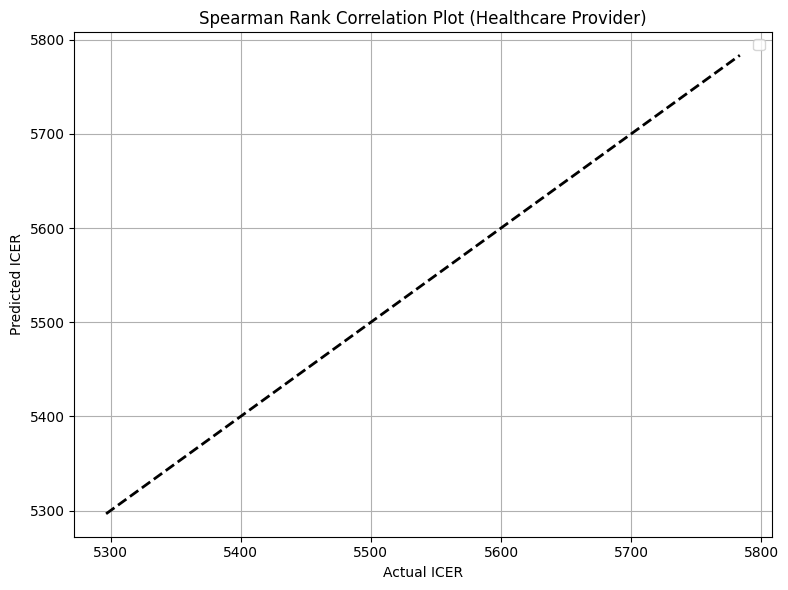

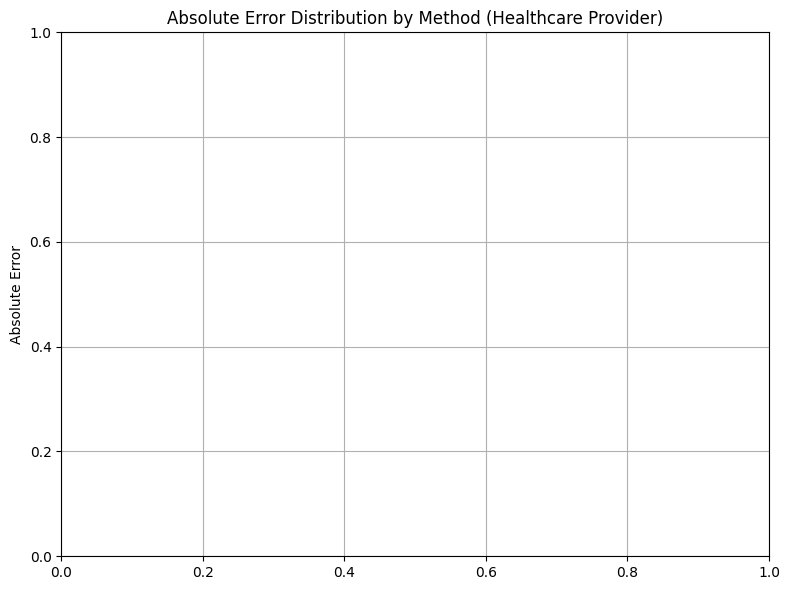



 ICER Evaluation from Payer's Perspective


C:\Users\jessi\AppData\Local\Temp\ipykernel_7844\2680994249.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


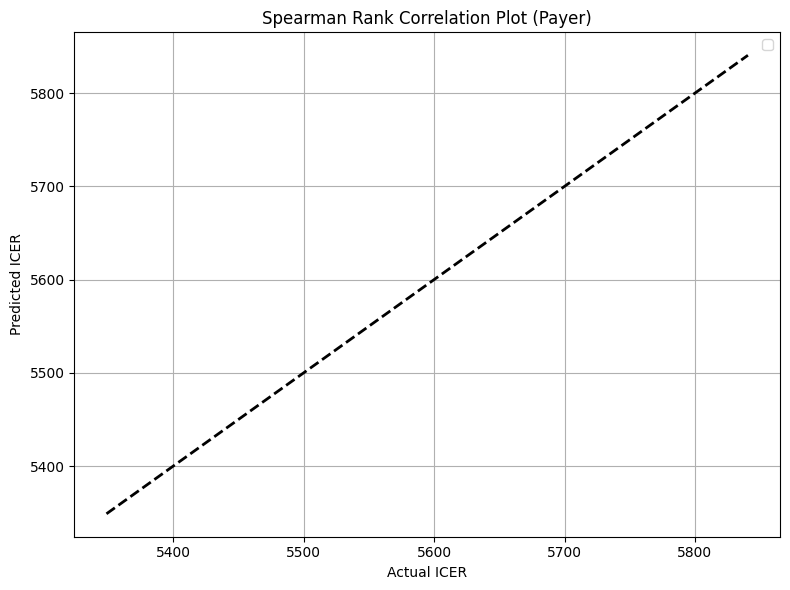

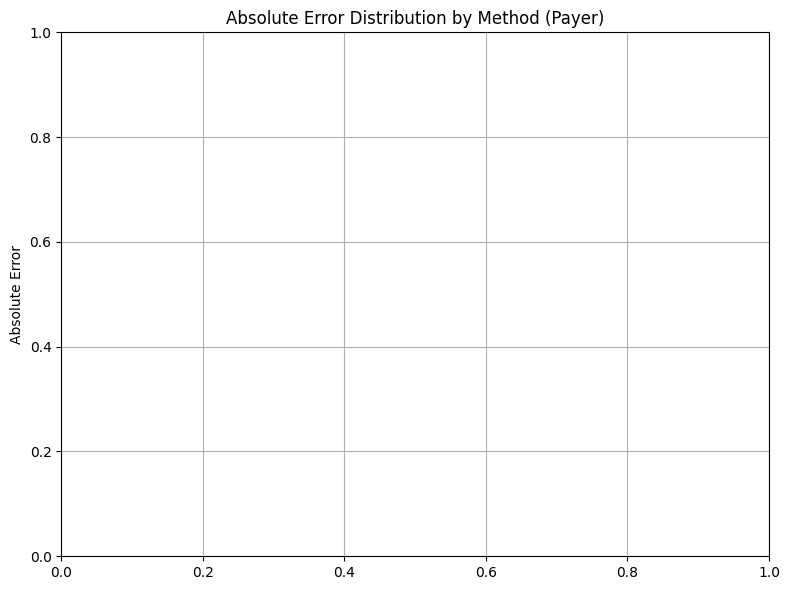

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import spearmanr

# Define ICER method columns per perspective
perspectives = {
    'Healthcare Provider': {
        'true': 'icer_healthcare_observed',
        'methods': {
            'RF': 'icer_healthcare_rf',
            'Equal Split': 'icer_healthcare_equal_bm',
            'Pop-Based Split': 'icer_healthcare_prop_bm'
        }
    },
    'Payer': {
        'true': 'icer_payer_observed',
        'methods': {
            'RF': 'icer_payer_rf',
            'Equal Split': 'icer_payer_equal_bm',
            'Pop-Based Split': 'icer_payer_prop_bm'
        }
    }
}

for perspective, setup in perspectives.items():
    print(f"\n\n ICER Evaluation from {perspective}'s Perspective")

    true_col = setup['true']
    methods_dict = setup['methods']
    method_names = list(methods_dict.keys())

    results = []
    abs_errors = {}
    preds_dict = {}

    min_val, max_val = icer[true_col].min(), icer[true_col].max()

    # --- Plot 1: Spearman Rank Correlation ---
    plt.figure(figsize=(8, 6))
    markers = ['o', 's', '^']  # Add more if needed

    for i, (name, values) in enumerate(preds_dict.items()):
        rho, _ = spearmanr(values['true'], values['pred'])
        plt.scatter(values['true'], values['pred'], 
                    label=f"{name} (ρ={rho:.2f})", 
                    alpha=0.6, marker=markers[i], s=50)

    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    plt.xlabel("Actual ICER")
    plt.ylabel("Predicted ICER")
    plt.title(f"Spearman Rank Correlation Plot ({perspective})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    # --- Plot 2: Bland-Altman Plot ---
    for name, values in preds_dict.items():
        true = values['true']
        pred = values['pred']
        avg = (true + pred) / 2
        diff = pred - true
        mean_diff = np.mean(diff)
        sd_diff = np.std(diff)

        plt.figure(figsize=(8, 6))
        plt.scatter(avg, diff, alpha=0.6)
        plt.axhline(mean_diff, color='gray', linestyle='--', label=f"Mean diff: {mean_diff:.2f}")
        plt.axhline(mean_diff + 1.96*sd_diff, color='red', linestyle='--', label="+1.96 SD")
        plt.axhline(mean_diff - 1.96*sd_diff, color='red', linestyle='--', label="-1.96 SD")
        plt.xlabel("Average of Predicted and Actual ICER")
        plt.ylabel("Difference (Predicted - Actual)")
        plt.title(f"Bland-Altman Plot for {name} ({perspective})")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # --- Plot 3: Boxplot of Absolute Errors ---
    abs_errors_df = pd.DataFrame({
        name: abs_errors[name].reset_index(drop=True)
        for name in abs_errors
    })
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=abs_errors_df)
    plt.title(f"Absolute Error Distribution by Method ({perspective})")
    plt.ylabel("Absolute Error")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


 Performance Metrics for Predicted Cases:
         Method        MAE  Normalized MAE (%)       RMSE
             RF 416.809123           52.234144 538.708709
    Equal Split 530.893939           64.750342 771.082572
Pop-Based Split 465.937421           56.827937 720.675577


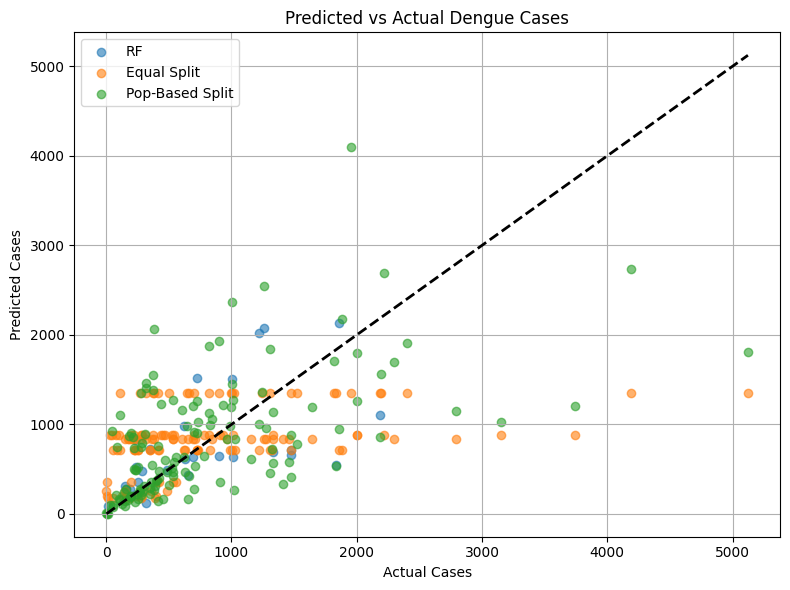

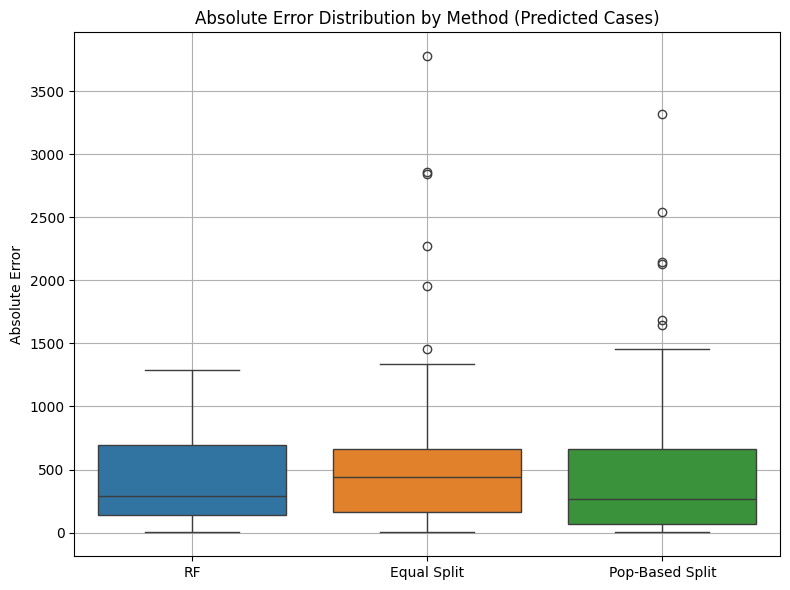

In [72]:
# evaluation metric for predicted cases
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import wilcoxon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# Define prediction columns and ground truth
case_methods = {
    'RF': 'rf_preds',
    'Equal Split': 'cases_bm_equal',
    'Pop-Based Split': 'cases_prop_bm'
}

true_cases_col = 'Cases'
method_names = list(case_methods.keys())

# Step 1: Metrics
results = []
preds_dict = {}
abs_errors = {}

for name, col in case_methods.items():
    valid_idx = icer[col].notna()
    true = icer.loc[valid_idx, true_cases_col]
    pred = icer.loc[valid_idx, col]

    preds_dict[name] = {'true': true, 'pred': pred}
    abs_errors[name] = abs(pred - true)

    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))

    # Normalized MAE as % of average observed cases per district
    avg_true = np.mean(true)
    if avg_true != 0:
        norm_mae_pct = (mae / avg_true) * 100
    else:
        norm_mae_pct = np.nan  # Handle potential divide-by-zero

    results.append({
        'Method': name,
        'MAE': mae,
        'Normalized MAE (%)': norm_mae_pct,
        'RMSE': rmse
    })


results_df = pd.DataFrame(results)
print("\n Performance Metrics for Predicted Cases:")
print(results_df.to_string(index=False))

# Step 2: Scatter Plot - Predicted vs Actual
plt.figure(figsize=(8, 6))
for name, col in case_methods.items():
    valid_idx = icer[col].notna()
    plt.scatter(icer.loc[valid_idx, true_cases_col], icer.loc[valid_idx, col], label=name, alpha=0.6)
min_val, max_val = icer[true_cases_col].min(), icer[true_cases_col].max()
plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
plt.xlabel("Actual Cases")
plt.ylabel("Predicted Cases")
plt.title("Predicted vs Actual Dengue Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 4: Boxplot - Absolute Errors
abs_errors_df = pd.DataFrame(abs_errors)
plt.figure(figsize=(8, 6))
sns.boxplot(data=abs_errors_df)
plt.title("Absolute Error Distribution by Method (Predicted Cases)")
plt.ylabel("Absolute Error")
plt.grid(True)
plt.tight_layout()
plt.show()